In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime as dt
from scipy import stats
from scipy.stats import kurtosis
from scipy.signal import find_peaks

In [22]:
df = pd.read_csv('power_usage_2016_to_2020.csv')
df.head()

,StartDate,Value (kWh),day_of_week,notes
0,2016-01-06 00:00:00,1.057,2,weekday
1,2016-01-06 01:00:00,1.171,2,weekday
2,2016-01-06 02:00:00,0.560,2,weekday
3,2016-01-06 03:00:00,0.828,2,weekday
4,2016-01-06 04:00:00,0.932,2,weekday


In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35952 entries, 0 to 35951
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   StartDate    35952 non-null  object 
 1   Value (kWh)  35952 non-null  float64
 2   day_of_week  35952 non-null  int64  
 3   notes        35952 non-null  object 
dtypes: float64(1), int64(1), object(2)
memory usage: 1.1+ MB


In [24]:
# Исправление даты согласно инструкции Kaggle
n = df.shape[0]
p1 = pd.Series(range(n), pd.period_range('2016-06-01 00:00:00', freq='1H', periods=n))
df['StartDate'] = p1.to_frame().index

In [25]:
df['StartDate'] = df['StartDate'].dt.to_timestamp()

In [26]:
df.set_index('StartDate', inplace=True)
df.sort_index(inplace=True)

In [ ]:
df.columns = ['value_kwh', 'day_of_week', 'notes']
df.head()

,value_kwh,day_of_week,notes
StartDate,,,
2016-06-01 00:00:00,1.057,2,weekday
2016-06-01 01:00:00,1.171,2,weekday
2016-06-01 02:00:00,0.560,2,weekday
2016-06-01 03:00:00,0.828,2,weekday
2016-06-01 04:00:00,0.932,2,weekday


Text(0, 0.5, 'Потребление (kWh)')

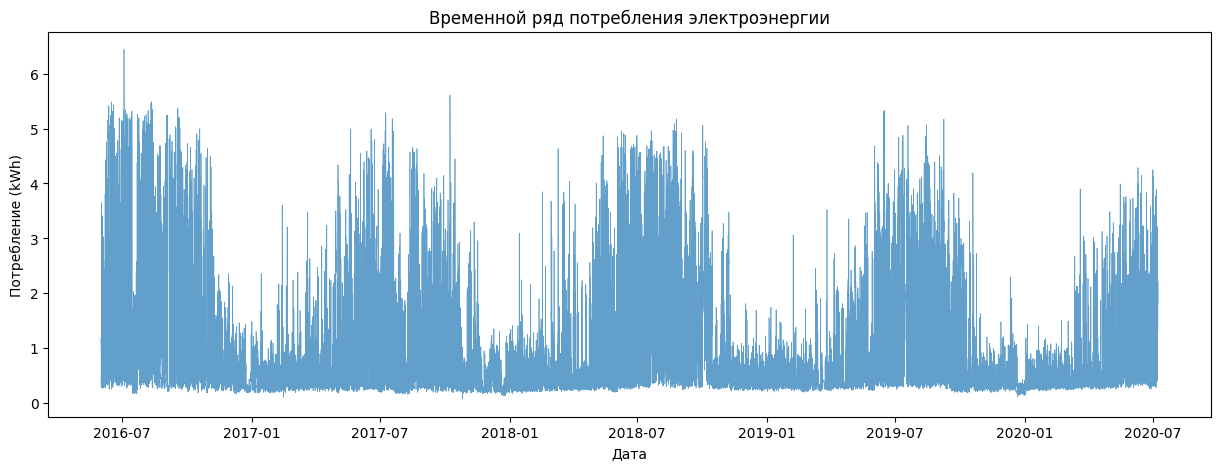

In [29]:
plt.figure(figsize=(15, 5))
plt.plot(df.index, df['value_kwh'], linewidth=0.5, alpha=0.7)
plt.title('Временной ряд потребления электроэнергии')
plt.xlabel('Дата')
plt.ylabel('Потребление (kWh)')

In [30]:
df['year'] = df.index.year
df['quarter'] = df.index.quarter
df['month'] = df.index.month
df['week'] = df.index.isocalendar().week
df['day'] = df.index.day
df['dayofweek'] = df.index.dayofweek
df['hour'] = df.index.hour

In [31]:
df['is_weekend'] = (df['dayofweek'] >= 5).astype(int)
df['is_night'] = ((df['hour'] >= 22) | (df['hour'] <= 6)).astype(int)
df['is_morning'] = ((df['hour'] >= 7) & (df['hour'] <= 11)).astype(int)
df['is_afternoon'] = ((df['hour'] >= 12) & (df['hour'] <= 17)).astype(int)
df['is_evening'] = ((df['hour'] >= 18) & (df['hour'] <= 21)).astype(int)

In [32]:
window_sizes = [6, 24, 168]

for window in window_sizes:
    df[f'rolling_mean_{window}'] = df['value_kwh'].rolling(window=window, min_periods=1).mean()
    df[f'rolling_std_{window}'] = df['value_kwh'].rolling(window=window, min_periods=1).std()
    df[f'rolling_min_{window}'] = df['value_kwh'].rolling(window=window, min_periods=1).min()
    df[f'rolling_max_{window}'] = df['value_kwh'].rolling(window=window, min_periods=1).max()
    df[f'rolling_range_{window}'] = df[f'rolling_max_{window}'] - df[f'rolling_min_{window}']
    
    if window >= 12:  
        df[f'rolling_q25_{window}'] = df['value_kwh'].rolling(window=window, min_periods=1).quantile(0.25)
        df[f'rolling_q75_{window}'] = df['value_kwh'].rolling(window=window, min_periods=1).quantile(0.75)
        df[f'rolling_iqr_{window}'] = df[f'rolling_q75_{window}'] - df[f'rolling_q25_{window}']

In [33]:
df['expanding_mean'] = df['value_kwh'].expanding(min_periods=24).mean()
df['expanding_std'] = df['value_kwh'].expanding(min_periods=24).std()

In [34]:
for lag in [1, 2, 3, 6, 12, 24, 168]:
    df[f'lag_{lag}'] = df['value_kwh'].shift(lag)

In [35]:
df['diff_1'] = df['value_kwh'].diff(periods=1)
df['diff_24'] = df['value_kwh'].diff(periods=24)
df['diff_168'] = df['value_kwh'].diff(periods=168)
df['pct_change_1'] = df['value_kwh'].pct_change(periods=1)
df['pct_change_24'] = df['value_kwh'].pct_change(periods=24)

In [36]:
df['rolling_skew_24'] = df['value_kwh'].rolling(window=24, min_periods=24).skew()
df['rolling_kurtosis_24'] = df['value_kwh'].rolling(window=24, min_periods=24).apply(
    lambda x: kurtosis(x, fisher=True) if len(x) >= 24 else np.nan
)

In [37]:
def is_holiday(date):
    month = date.month
    day = date.day
    dayofweek = date.dayofweek
    
    # Новый год
    if month == 1 and day == 1:
        return 1
    # Рождество
    elif month == 12 and day == 25:
        return 1
    # День благодарения (4-й четверг ноября)
    elif month == 11 and dayofweek == 3 and 22 <= day <= 28:
        return 1
    # День памяти (последний понедельник мая)
    elif month == 5 and dayofweek == 0 and day > 24:
        return 1
    # День труда (1-й понедельник сентября)
    elif month == 9 and dayofweek == 0 and day <= 7:
        return 1
    else:
        return 0

In [38]:
df['is_holiday'] = df.index.map(is_holiday)
df['is_dayoff'] = ((df['is_weekend'] == 1) | (df['is_holiday'] == 1)).astype(int)

In [39]:
df['season'] = df['month'].apply(lambda x: 
    0 if x in [12, 1, 2] else  
    1 if x in [3, 4, 5] else    
    2 if x in [6, 7, 8] else   
    3)                       


In [40]:
df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
df['dayofweek_sin'] = np.sin(2 * np.pi * df['dayofweek'] / 7)
df['dayofweek_cos'] = np.cos(2 * np.pi * df['dayofweek'] / 7)
df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)

Text(0, 0.5, 'Плотность вероятности')

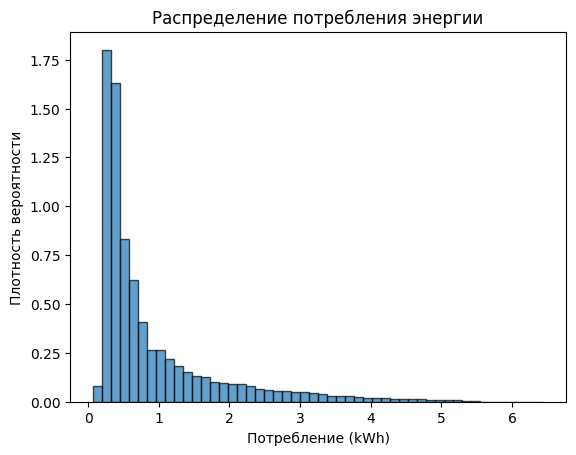

In [41]:
plt.hist(df['value_kwh'].dropna(), bins=50, edgecolor='black', alpha=0.7, density=True)
plt.title('Распределение потребления энергии')
plt.xlabel('Потребление (kWh)')
plt.ylabel('Плотность вероятности')

([<matplotlib.axis.XTick at 0x7f3959ecae90>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

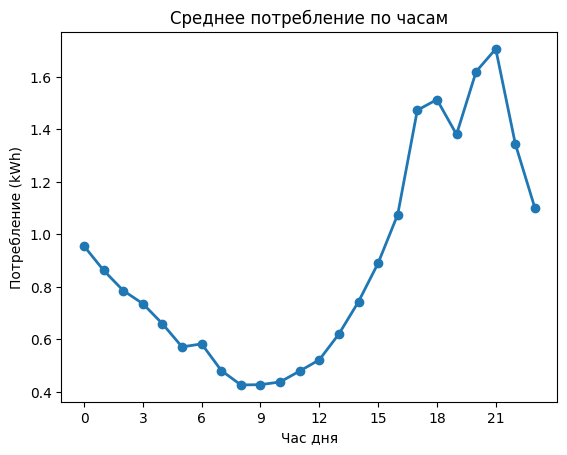

In [43]:
hourly_avg = df.groupby('hour')['value_kwh'].mean()
plt.plot(hourly_avg.index, hourly_avg.values, marker='o', linewidth=2)
plt.title('Среднее потребление по часам')
plt.xlabel('Час дня')
plt.ylabel('Потребление (kWh)')
plt.xticks(range(0, 24, 3))

([<matplotlib.axis.XTick at 0x7f39597cb810>,
 [Text(0, 0, 'Пн'),
  Text(1, 0, 'Вт'),
  Text(2, 0, 'Ср'),
  Text(3, 0, 'Чт'),
  Text(4, 0, 'Пт'),
  Text(5, 0, 'Сб'),
  Text(6, 0, 'Вс')])

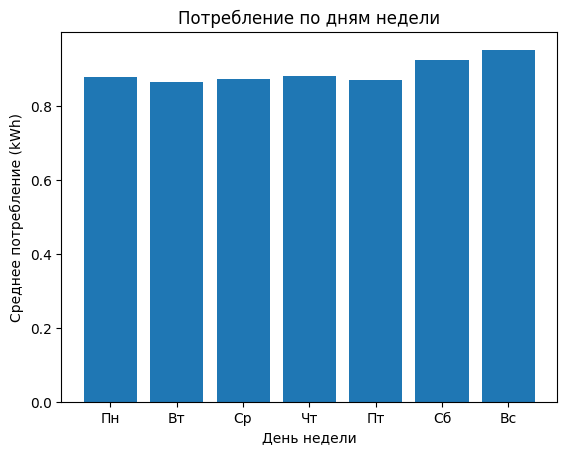

In [47]:
daily_avg = df.groupby('dayofweek')['value_kwh'].mean()
plt.bar(daily_avg.index, daily_avg.values)
plt.title('Потребление по дням недели')
plt.xlabel('День недели')
plt.ylabel('Среднее потребление (kWh)')
plt.xticks(range(7), labels=['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс'])

([<matplotlib.axis.XTick at 0x7f3959674b50>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

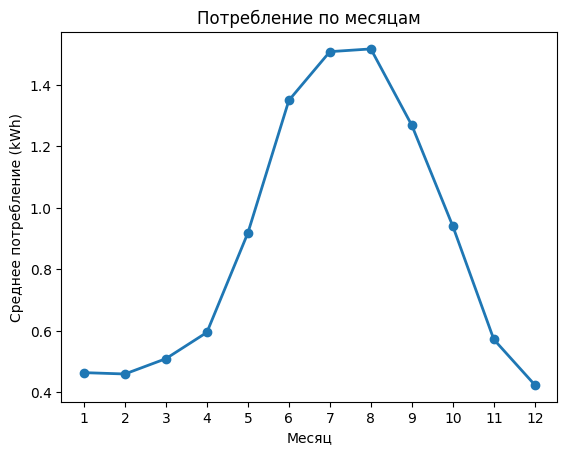

In [50]:
monthly_avg = df.groupby('month')['value_kwh'].mean()
plt.plot(monthly_avg.index, monthly_avg.values, marker='o', linewidth=2)
plt.title('Потребление по месяцам')
plt.xlabel('Месяц')
plt.ylabel('Среднее потребление (kWh)')
plt.xticks(range(1, 13))

(array([17167., 17168., 17169., 17170., 17171., 17172., 17173., 17174.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

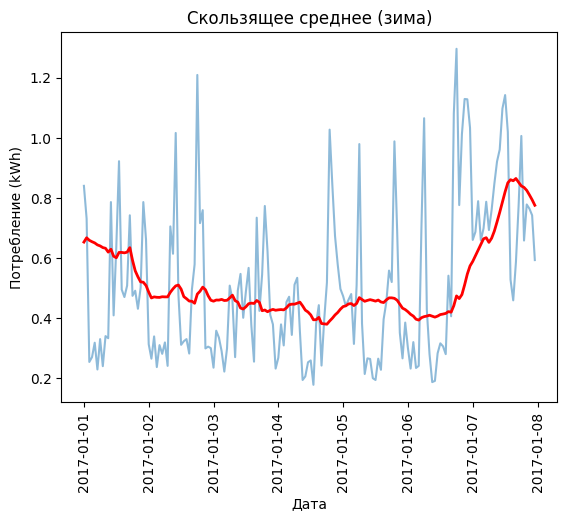

In [54]:
sample_winter = df.loc['2017-01-01':'2017-01-07']  # Зимняя неделя
plt.plot(sample_winter.index, sample_winter['value_kwh'], alpha=0.5, label='Исходные')
plt.plot(sample_winter.index, sample_winter['rolling_mean_24'], linewidth=2, label='Скользящее ср. 24ч', color='red')
plt.title('Скользящее среднее (зима)')
plt.xlabel('Дата')
plt.ylabel('Потребление (kWh)')
plt.xticks(rotation=90)


Text(0, 0.5, 'Плотность вероятности')

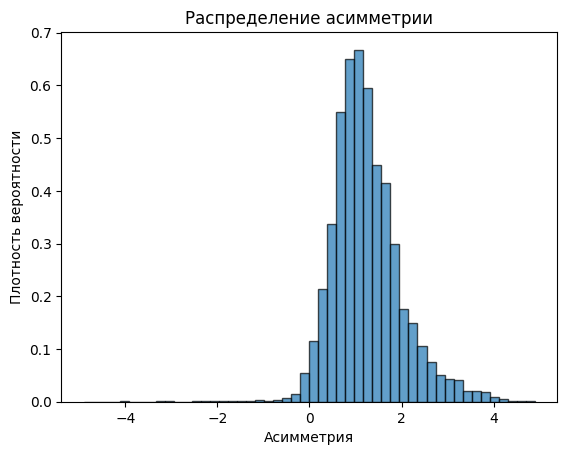

In [72]:
skewness = df['rolling_skew_24'].dropna()
plt.hist(skewness, bins=50, edgecolor='black', alpha=0.7, density=True)
plt.title('Распределение асимметрии')
plt.xlabel('Асимметрия')
plt.ylabel('Плотность вероятности')

Text(0, 0.5, 'Плотность вероятности')

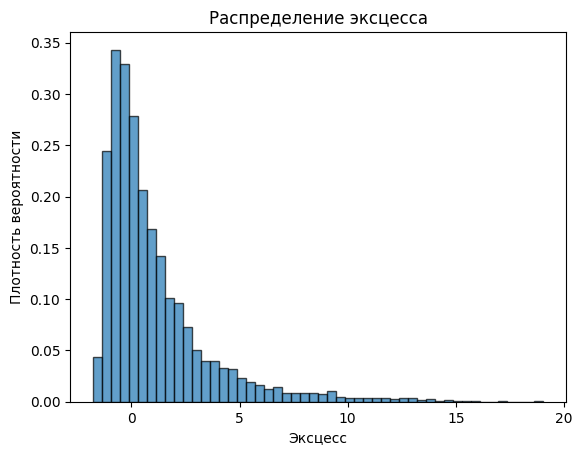

In [60]:

kurt = df['rolling_kurtosis_24'].dropna()
plt.hist(kurt, bins=50, edgecolor='black', alpha=0.7, density=True)
plt.title('Распределение эксцесса')
plt.xlabel('Эксцесс')
plt.ylabel('Плотность вероятности')

Text(0, 0.5, 'Эксцесс')

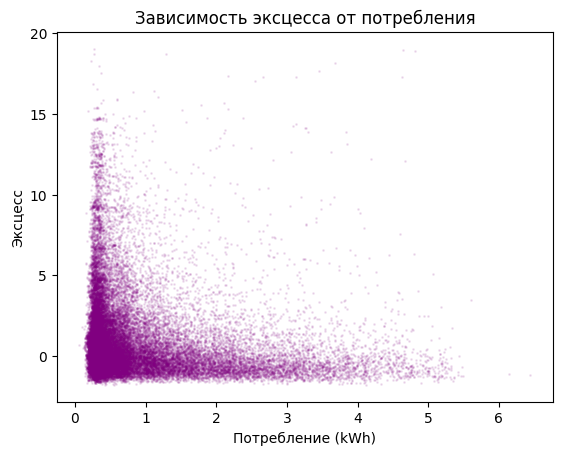

In [62]:
valid_idx = df['rolling_kurtosis_24'].notna() & df['value_kwh'].notna()
plt.scatter(df.loc[valid_idx, 'value_kwh'], df.loc[valid_idx, 'rolling_kurtosis_24'], 
            alpha=0.1, s=1, c='purple')
plt.title('Зависимость эксцесса от потребления')
plt.xlabel('Потребление (kWh)')
plt.ylabel('Эксцесс')

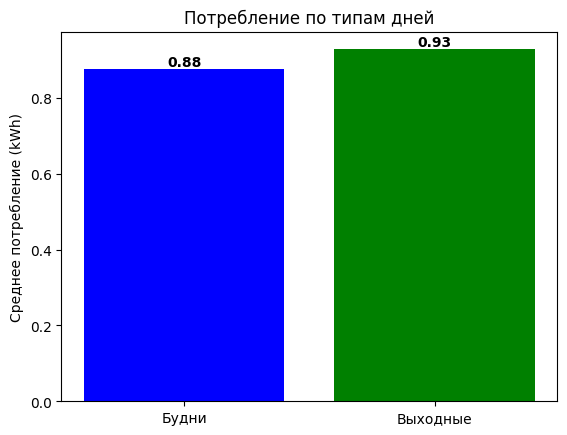

In [66]:
day_type_avg = df.groupby('is_dayoff')['value_kwh'].mean()
plt.bar(['Будни', 'Выходные'], day_type_avg.values, color=['blue', 'green'])
plt.title('Потребление по типам дней')
plt.ylabel('Среднее потребление (kWh)')
for i, v in enumerate(day_type_avg.values):
    plt.text(i, v, f'{v:.2f}', ha='center', va='bottom', fontweight='bold')

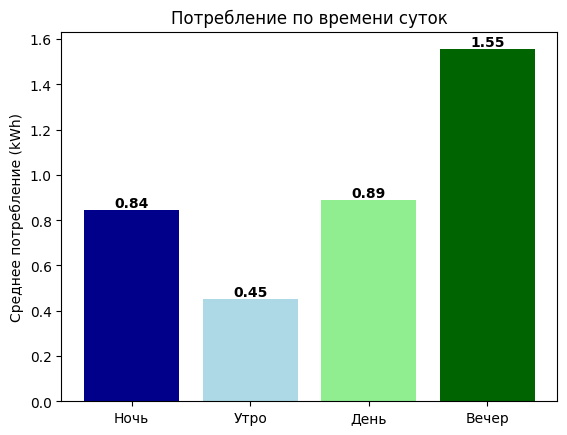

In [68]:
time_of_day = ['Ночь', 'Утро', 'День', 'Вечер']
time_cols = ['is_night', 'is_morning', 'is_afternoon', 'is_evening']
time_avg = [df.loc[df[col] == 1, 'value_kwh'].mean() for col in time_cols]
colors = ['darkblue', 'lightblue', 'lightgreen', 'darkgreen']
bars = plt.bar(time_of_day, time_avg, color=colors)
plt.title('Потребление по времени суток')
plt.ylabel('Среднее потребление (kWh)')
for bar, v in zip(bars, time_avg):
    plt.text(bar.get_x() + bar.get_width()/2, v, f'{v:.2f}', 
             ha='center', va='bottom', fontweight='bold')

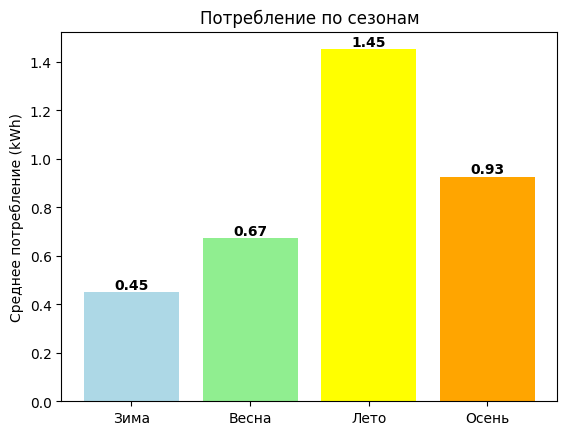

In [71]:
season_names = ['Зима', 'Весна', 'Лето', 'Осень']
season_avg = df.groupby('season')['value_kwh'].mean()
colors_season = ['lightblue', 'lightgreen', 'yellow', 'orange']
bars = plt.bar(season_names, season_avg.values, color=colors_season)
plt.title('Потребление по сезонам')
plt.ylabel('Среднее потребление (kWh)')
for bar, v in zip(bars, season_avg.values):
    plt.text(bar.get_x() + bar.get_width()/2, v, f'{v:.2f}', 
             ha='center', va='bottom', fontweight='bold')

In [73]:
mean_val = df['value_kwh'].mean()
median_val = df['value_kwh'].median()
mode_val = df['value_kwh'].mode()[0] if not df['value_kwh'].mode().empty else np.nan
std_val = df['value_kwh'].std()
skew_val = df['value_kwh'].skew()
kurt_val = kurtosis(df['value_kwh'].dropna(), fisher=True)

In [74]:
print(f"Среднее: {mean_val:.4f} kWh")
print(f"Медиана: {median_val:.4f} kWh")
print(f"Мода: {mode_val:.4f} kWh")
print(f"Стандартное отклонение: {std_val:.4f} kWh")
print(f"Асимметрия: {skew_val:.4f}")
print(f"Эксцесс: {kurt_val:.4f}")

Среднее: 0.8916 kWh
Медиана: 0.5010 kWh
Мода: 0.2780 kWh
Стандартное отклонение: 0.9081 kWh
Асимметрия: 2.1285
Эксцесс: 4.5325


In [75]:
# Анализ асимметрии
if abs(skew_val) < 0.5:
    print(f"Распределение примерно симметричное (|асимметрия| < 0.5)")
elif skew_val > 0:
    if skew_val < 1:
        print(f"Умеренная правосторонняя асимметрия (0.5 < асимметрия < 1)")
    else:
        print(f"Сильная правосторонняя асимметрия (асимметрия > 1)")
else:
    if skew_val > -1:
        print(f"Умеренная левосторонняя асимметрия (-1 < асимметрия < -0.5)")
    else:
        print(f"Сильная левосторонняя асимметрия (асимметрия < -1)")


print(f"Коэффициент асимметрии Пирсона: {(mean_val - mode_val)/std_val:.4f}")


Сильная правосторонняя асимметрия (асимметрия > 1)
Коэффициент асимметрии Пирсона: 0.6757


In [76]:
# Анализ эксцесса
if abs(kurt_val) < 0.5:
    print(f"Распределение близко к нормальному по эксцессу (|эксцесс| < 0.5)")
elif kurt_val > 0:
    if kurt_val < 3:
        print(f"Умеренный положительный эксцесс (0.5 < эксцесс < 3)")
    else:
        print(f"Сильный положительный эксцесс (эксцесс > 3)")
else:
    if kurt_val > -3:
        print(f"Умеренный отрицательный эксцесс (-3 < эксцесс < -0.5)")
    else:
        print(f"Сильный отрицательный эксцесс (эксцесс < -3)")


Сильный положительный эксцесс (эксцесс > 3)


In [ ]:
from tsfresh import extract_features, select_features
from tsfresh.utilities.dataframe_functions import impute
from tsfresh.feature_extraction import MinimalFCParameters, EfficientFCParameters, ComprehensiveFCParameters
from tsfresh.feature_extraction.settings import from_columns

In [85]:
df_tsfresh = df[['value_kwh']].copy()
df_tsfresh['id'] = 1 
df_tsfresh['time'] = range(len(df_tsfresh))

In [ ]:
extracted = extract_features(
        df_tsfresh[['id', 'time', 'value_kwh']],
        column_id='id',
        column_sort='time',
        default_fc_parameters=EfficientFCParameters(),
        n_jobs=1
    )
    

Feature Extraction: 100%|██████████| 1/1 [00:16<00:00, 16.08s/it]


In [ ]:
extracted

,value_kwh__variance_larger_than_standard_deviation,value_kwh__has_duplicate_max,value_kwh__has_duplicate_min,value_kwh__has_duplicate,value_kwh__sum_values,value_kwh__abs_energy,value_kwh__mean_abs_change,value_kwh__mean_change,value_kwh__mean_second_derivative_central,value_kwh__median,...,value_kwh__fourier_entropy__bins_5,value_kwh__fourier_entropy__bins_10,value_kwh__fourier_entropy__bins_100,value_kwh__permutation_entropy__dimension_3__tau_1,value_kwh__permutation_entropy__dimension_4__tau_1,value_kwh__permutation_entropy__dimension_5__tau_1,value_kwh__permutation_entropy__dimension_6__tau_1,value_kwh__permutation_entropy__dimension_7__tau_1,value_kwh__query_similarity_count__query_None__threshold_0.0,value_kwh__mean_n_absolute_max__number_of_maxima_7
1,0.0,0.0,0.0,1.0,32055.923712,58231.020215,0.292292,0.000021,-0.000007,0.501,...,0.090729,0.200814,1.23434,1.746523,3.03946,4.491522,6.059086,7.665001,NaN,5.724
